<a href="https://colab.research.google.com/github/YoussefSultan1/Image-Classification-in-Self-Driving-Cars/blob/main/Image_Classification_in_Self_Driving_Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _**Here's a brief overview of what code is doing:**_ ⬇

---


## **Data Acquisition**
The script begins with connecting to Google Drive to load the data and uploading any necessary files. Then, it downloads a dataset from Kaggle, which appears to be a preprocessed dataset of traffic signs.

## **Data Preparation**
The downloaded dataset is a pickle file, so it's loaded into memory. The labels are converted to one-hot encoded format, and the data is reshaped so that the channels are last. Also, it only keeps 60% of the training data to avoid overloading RAM.

## **Exploratory Data Analysis**
The script visualizes some training examples and saves the plot.

## **Model Definition**
The script defines a Convolutional Neural Network (CNN) model using Keras. The model consists of a convolutional layer, a max pooling layer, a flatten layer, a dense layer, and an output layer with a softmax activation function.

## **Model Compilation and Training**
The model is compiled using the Adam optimizer and the categorical cross-entropy loss function. Then, it's trained on a small subset of data for demonstrating overfitting. It uses a learning rate scheduler callback during the training process.

## **Performance Evaluation**
The script plots the training and validation accuracy of the model and provides a summary of the training results. Then it saves these plots for future use.

## **Hyperparameter Tuning**
The script trains multiple models with different filter sizes for the convolutional layer, saves these models, and compares their performance.

## **Final Evaluation**
The script reloads the saved models and their training histories and compares their performance using plots. It also performs predictions on the test dataset and evaluates their accuracy.

## **Prediction on Single Image**
The script selects an individual test image and predicts its class using the trained models.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahmoudm0stafa","key":"bdc4674e5389b6f61b7d57a7da6127bd"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed -p '/content/drive/MyDrive/project/dataset.zip'

100% 4.16G/4.16G [00:41<00:00, 242MB/s]
100% 4.16G/4.16G [00:41<00:00, 108MB/s]


In [ ]:
!unzip -q '/content/drive/MyDrive/project/dataset.zip/traffic-signs-preprocessed.zip' -d '/content/drive/MyDrive/project/dataset'

### Printing the list of files in a directory
This code imports necessary libraries and defines the input directory. It uses the `os.walk()` function to iterate over all files in a specified directory and its subdirectories, printing their full path. It then prints a list of all files in the specified directory. This is a useful technique for quickly inspecting the contents of a directory.

In [ ]:
import os
import pickle
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore", message="Clipping input data to the valid range for imshow")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (AvgPool2D, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPool2D, Reshape)
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# Define input directory
INPUT_DIR = '/content/drive/MyDrive/project/dataset'

# Print all files under the input directory
for root, dirs, files in os.walk(INPUT_DIR):
    for filename in files:
        print(os.path.join(root, filename))

# Print list of files under the input directory
print(os.listdir(INPUT_DIR))

/content/drive/MyDrive/project/dataset/data0.pickle
/content/drive/MyDrive/project/dataset/data1.pickle
/content/drive/MyDrive/project/dataset/data2.pickle
/content/drive/MyDrive/project/dataset/data3.pickle
/content/drive/MyDrive/project/dataset/data4.pickle
/content/drive/MyDrive/project/dataset/data5.pickle
/content/drive/MyDrive/project/dataset/data6.pickle
/content/drive/MyDrive/project/dataset/data7.pickle
/content/drive/MyDrive/project/dataset/data8.pickle
/content/drive/MyDrive/project/dataset/datasets_preparing.py
/content/drive/MyDrive/project/dataset/label_names.csv
/content/drive/MyDrive/project/dataset/test.pickle
/content/drive/MyDrive/project/dataset/std_rgb.pickle
/content/drive/MyDrive/project/dataset/std_gray.pickle
/content/drive/MyDrive/project/dataset/mean_image_rgb.pickle
/content/drive/MyDrive/project/dataset/mean_image_gray.pickle
/content/drive/MyDrive/project/dataset/labels.pickle
/content/drive/MyDrive/project/dataset/train.pickle
/content/drive/MyDrive/proje

### Loading and preprocessing the dataset
This script loads traffic sign image data from a pickle file, and prepares it for use in the Keras deep learning framework. The script uses the `to_categorical()` function to convert class vectors to binary class matrices, and transposes the image data to make channels come at the end. Finally, it prints the shapes of the loaded data.

In [ ]:
# Open pickle file for reading in binary mode
with open('/content/drive/MyDrive/project/dataset/data2.pickle', 'rb') as file:
    # Load data from pickle file
    data = pickle.load(file, encoding='latin1')

# Convert labels to one-hot encoding
num_classes = 43
data['y_train'] = to_categorical(data['y_train'], num_classes=num_classes)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=num_classes)

# Transpose arrays to make channels come at the end
data['x_train'] = data['x_train'].transpose((0, 2, 3, 1))
data['x_validation'] = data['x_validation'].transpose((0, 2, 3, 1))
data['x_test'] = data['x_test'].transpose((0, 2, 3, 1))

# Reduce the size of the training dataset to 60%, to avoid RAM overloading
train_size = int(0.6 * len(data['x_train']))
data['x_train'] = data['x_train'][:train_size]
data['y_train'] = data['y_train'][:train_size]

# Print shapes of loaded data from file
for key, value in data.items():
    if key == 'labels':
        print(f"{key}: {len(value)}")
    else:
        print(f"{key}: {value.shape}")

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (52193, 32, 32, 3)
y_train: (52193, 43)
labels: 43
x_test: (12630, 32, 32, 3)


### Visualizing examples of training data in grid format using matplotlib
This code creates a grid of example images from the training data using the `convert_to_grid()` function. The `matplotlib` library is used to display the grid and save it as a PNG file. The function takes a 4D tensor as input and scales the pixel values to the range [0, 255]. The resulting grid is then plotted using imshow and the `gray` color map. The resulting plot is displayed and saved as 'training_examples.png'.

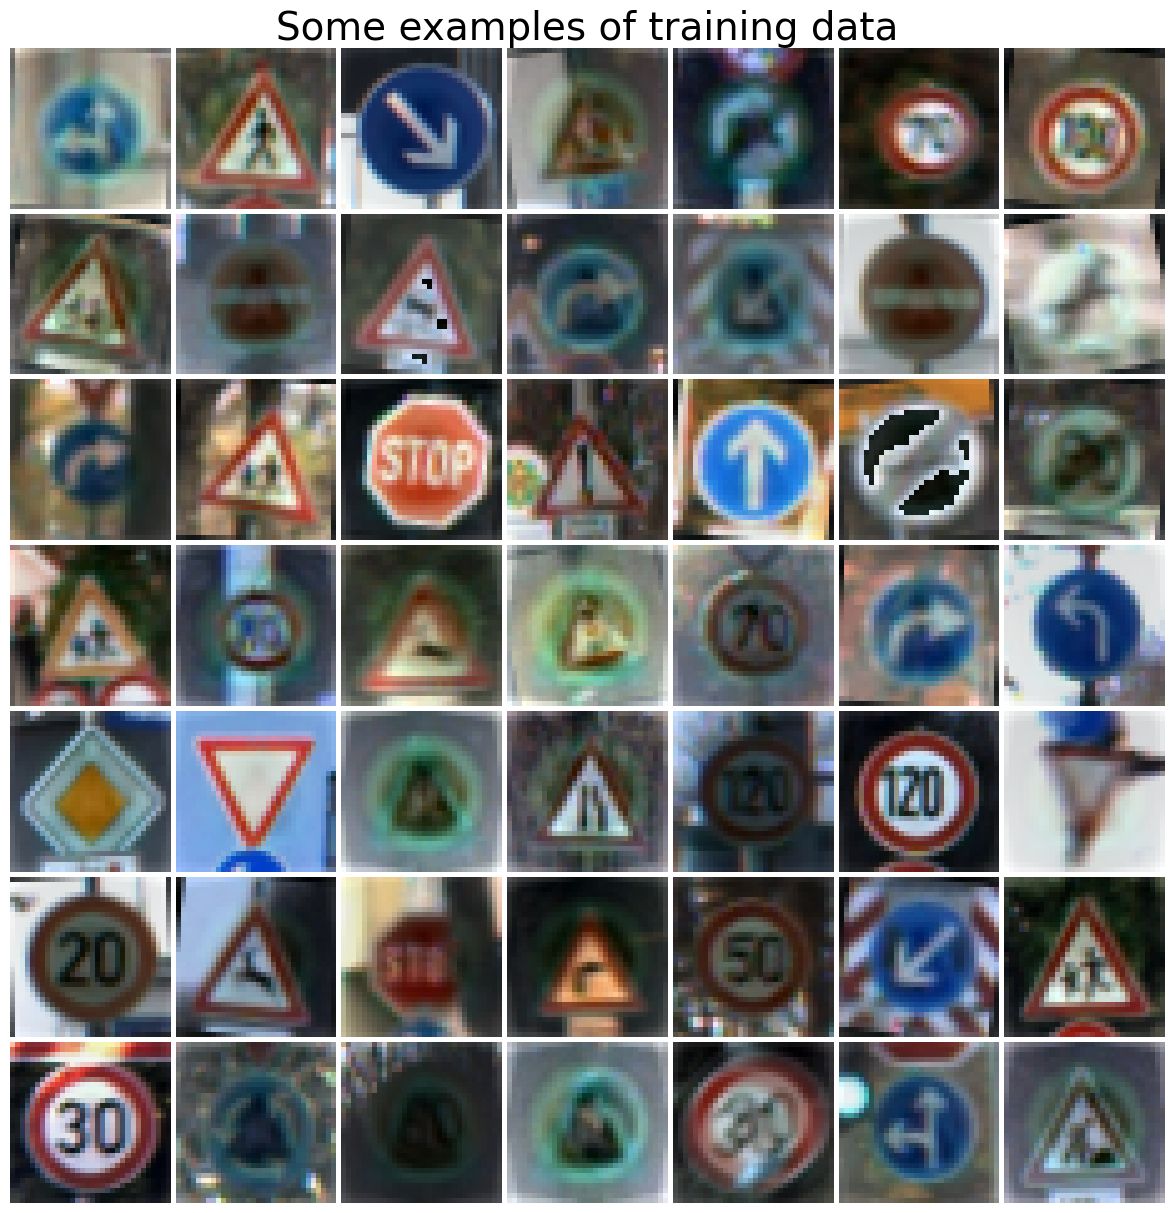

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Define function to convert a 4D tensor to a grid
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1
    return grid

# Define examples and plot them
examples = data['x_train'][:49, :, :, :]
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=28)
plt.show()

# Save the plot
fig.savefig('/content/drive/MyDrive/project/training_examples.png')
plt.close()


### Simple CNN model using Keras
The code defines a Sequential model, which includes a convolutional layer, a max pooling layer, a flatten layer, and two dense layers. The model is then compiled using Adam optimizer, categorical crossentropy loss, and accuracy metric. The model is trained for 15 epochs with a learning rate annealer callback.

In [ ]:
# Define a Sequential model
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))

# Add a max pooling layer with 2x2 pool size
model.add(MaxPool2D(pool_size=2))

# Flatten the output from the convolutional layer
model.add(Flatten())

# Add a dense layer with 500 units and ReLU activation
model.add(Dense(500, activation='relu'))

# Add the output layer with 43 units and softmax activation
model.add(Dense(43, activation='softmax'))

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Defining the learning rate annealer callback function
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))

# Training the model
epochs = 15
h = model.fit(data['x_train'][:10], data['y_train'][:10],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)

Epoch 1/15
2/2 [==============================] - 16s 3s/step - loss: 3.7975 - accuracy: 0.0000e+00 - val_loss: 3.8552 - val_accuracy: 0.0311 - lr: 4.6329e-04
Epoch 2/15
2/2 [==============================] - 3s 3s/step - loss: 2.9324 - accuracy: 0.3000 - val_loss: 4.2038 - val_accuracy: 0.0351 - lr: 4.4013e-04
Epoch 3/15
2/2 [==============================] - 3s 3s/step - loss: 2.3857 - accuracy: 0.5000 - val_loss: 4.6995 - val_accuracy: 0.0361 - lr: 4.1812e-04
Epoch 4/15
2/2 [==============================] - 3s 3s/step - loss: 1.9355 - accuracy: 0.5000 - val_loss: 5.2786 - val_accuracy: 0.0399 - lr: 3.9721e-04
Epoch 5/15
2/2 [==============================] - 3s 3s/step - loss: 1.6220 - accuracy: 0.6000 - val_loss: 5.8612 - val_accuracy: 0.0413 - lr: 3.7735e-04
Epoch 6/15
2/2 [==============================] - 3s 3s/step - loss: 1.3701 - accuracy: 0.6000 - val_loss: 6.4341 - val_accuracy: 0.0392 - lr: 3.5849e-04
Epoch 7/15
2/2 [==============================] - 2s 2s/step - loss: 1.

### Print acc and val_acc
Printing the training and validation accuracy after training the model.

In [ ]:
print('Epochs={0:d}, training accuracy: {1:.4f}, validation accuracy: {2:.4f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))

Epochs=15, training accuracy: 1.0000, validation accuracy: 0.0424


### Visualizing Overfitting using Accuracy vs. Epoch plot
This code generates a plot of the training and validation accuracy of the model as a function of epoch. The plot helps visualize overfitting on small amount of data. Additionally, the code prints a summary of the training results, including the number of epochs and the maximum training and validation accuracy achieved.

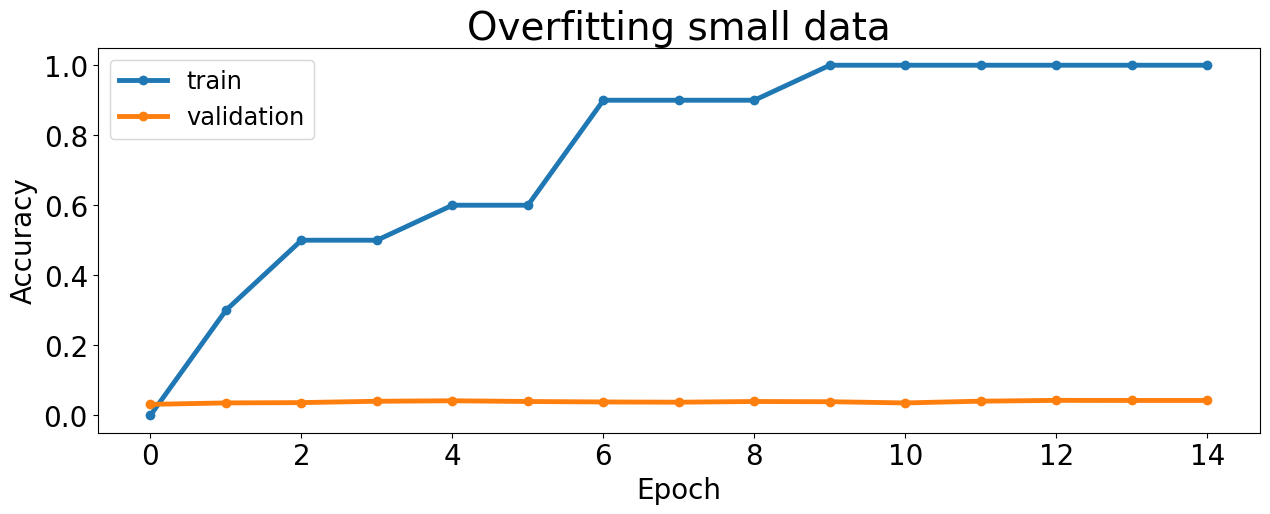

Training Summary:-
Epochs: 15, Training Accuracy: 1.0000, Validation Accuracy: 0.0424


In [ ]:
import matplotlib.pyplot as plt

# Set default plot configurations
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.family'] = 'Arial'

# Plotting accuracy vs. epochs for train and validation sets
fig = plt.figure()
plt.plot(h.history['accuracy'], '-o', linewidth=3.5)
plt.plot(h.history['val_accuracy'], '-o', linewidth=3.5)
plt.title('Overfitting small data', fontsize=28)
plt.legend(['train', 'validation'], loc='upper left', fontsize='xx-large')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.tick_params(labelsize=20)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('overfitting_small_data.png')
plt.close()

# Print summary of training results
epochs = len(h.history['accuracy'])
train_accuracy = max(h.history['accuracy'])
val_accuracy = max(h.history['val_accuracy'])
print('Training Summary:-\nEpochs: {0:d}, Training Accuracy: {1:.4f}, Validation Accuracy: {2:.4f}'.format(epochs, train_accuracy, val_accuracy))

### Building, Training, and Saving a Set of CNN Models with Different Filter Sizes using Keras
In this code, we build and train a set of convolutional neural network (CNN) models with Keras, using various filter sizes ranging from 3x3 to 31x31. We train each model for 5 epochs and implement a learning rate scheduler to optimize the learning rate during training. Afterwards, we save the architecture and parameters of each trained model to a file for future use (to ensure that they can be used later without the need for retraining). Finally, we print the training and validation accuracies for each model to compare their performance on a classification task. This code enables us to efficiently explore the effect of different filter sizes on the accuracy of CNN models.

In [ ]:
# Define a list of different filter sizes to try
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]

# Loop over the filters and create, train, and save models one by one
for i in range(len(filters)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=filters[i], padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(43, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
    epochs = 5

    history = model.fit(data['x_train'], data['y_train'],
                        batch_size=8, epochs=epochs,
                        validation_data=(data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=0)

    print('Model with filters: {0:d}x{0:d}, epochs: {1:d}, training accuracy: {2:.4f}, validation accuracy: {3:.4f}'.format(filters[i], epochs, max(history.history['accuracy']), max(history.history['val_accuracy'])))

    # Save the model architecture and weights to a file
    model_name = "/content/drive/MyDrive/project/model-{}x{}.h5".format(filters[i], filters[i])
    model.save(model_name)

    # Save the history object to a file
    with open('/content/drive/MyDrive/project/history-{}x{}.pkl'.format(filters[i], filters[i]), 'wb') as f:
        pickle.dump(history.history, f)

    # Clear TensorFlow session and variables
    tf.keras.backend.clear_session()


Model with filters: 3x3, epochs: 5, training accuracy: 0.9861, validation accuracy: 0.8796
Model with filters: 5x5, epochs: 5, training accuracy: 0.9854, validation accuracy: 0.8778
Model with filters: 9x9, epochs: 5, training accuracy: 0.9797, validation accuracy: 0.8560
Model with filters: 13x13, epochs: 5, training accuracy: 0.9732, validation accuracy: 0.8113
Model with filters: 15x15, epochs: 5, training accuracy: 0.9690, validation accuracy: 0.8458
Model with filters: 19x19, epochs: 5, training accuracy: 0.9607, validation accuracy: 0.8345
Model with filters: 23x23, epochs: 5, training accuracy: 0.9547, validation accuracy: 0.8345
Model with filters: 25x25, epochs: 5, training accuracy: 0.9537, validation accuracy: 0.8147
Model with filters: 31x31, epochs: 5, training accuracy: 0.9439, validation accuracy: 0.8240


In [ ]:
    # Clear TensorFlow session and variables
    tf.keras.backend.clear_session()
    model = None
    history = None

    # Clear Python variables
    del model
    del history

    # Collect garbage to release memory
    import gc
    gc.collect()

111

### Loading saved models
To load several trained models in Keras, you can use the `load_model()` function from the `keras.models` module. This function loads a saved model and returns a `keras.models.Model` object.
After all the models have been trained and saved, we first clear the models list using `models = []`. We then loop over the filters and load each saved model using the `load_model()` function, and assign the loaded model to the same index in the models list using `models.append(model)`

In [ ]:
# Redefine the list of different filter sizes
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]

# Clear the current models list
models = []
history = []

# Load the saved models and histories and assign them to the models list and history list
for i in range(len(filters)):
    model_name = "/content/drive/MyDrive/project/model-{}x{}.h5".format(filters[i], filters[i])
    model = load_model(model_name)
    models.append(model)

    # Load the history object from file
    with open('/content/drive/MyDrive/project/history-{}x{}.pkl'.format(filters[i], filters[i]), 'rb') as f:
        history.append(pickle.load(f))


### Plotting and printing accuracy results
This code imports the necessary libraries and sets the default size of plots and font family. It then plots the history of training and validation accuracy for different sizes of filters using a loop. The legend indicates the size of each filter, and the x-axis shows the epoch. The y-axis shows the accuracy values, and the title of the plot is "Accuracy for different sizes of filters".

After plotting the accuracy results, the code prints the training and validation accuracy values for each filter size using a loop. The results indicate the maximum accuracy achieved during training and validation for each filter size.

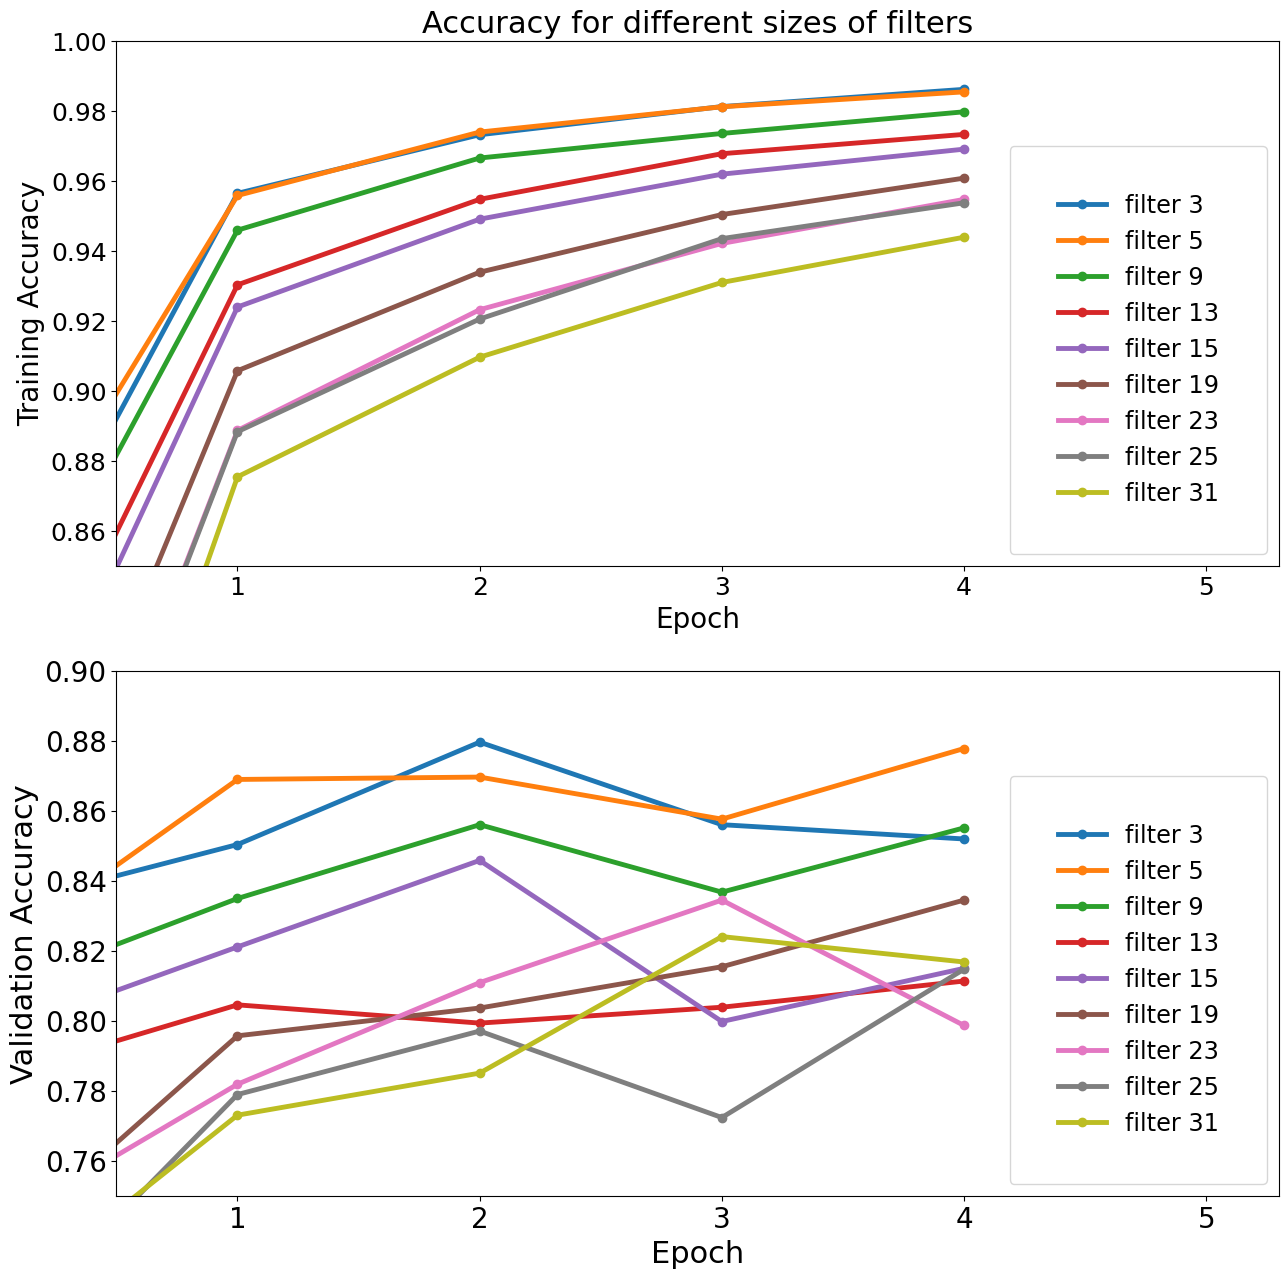

data2 filter 3 training accuracy = 0.98611
data2 filter 5 training accuracy = 0.98538
data2 filter 9 training accuracy = 0.97969
data2 filter 13 training accuracy = 0.97323
data2 filter 15 training accuracy = 0.96902
data2 filter 19 training accuracy = 0.96074
data2 filter 23 training accuracy = 0.95467
data2 filter 25 training accuracy = 0.95369
data2 filter 31 training accuracy = 0.94386

data2 filter 3 validation accuracy = 0.87959
data2 filter 5 validation accuracy = 0.87778
data2 filter 9 validation accuracy = 0.85601
data2 filter 13 validation accuracy = 0.81134
data2 filter 15 validation accuracy = 0.84580
data2 filter 19 validation accuracy = 0.83447
data2 filter 23 validation accuracy = 0.83447
data2 filter 25 validation accuracy = 0.81474
data2 filter 31 validation accuracy = 0.82404


In [ ]:
# Plotting history of training and validation accuracy

plt.rcParams['figure.figsize'] = (15.0, 15.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


fig = plt.figure()
plt.subplot(2, 1, 1)
for i in range(len(history)):
    plt.plot(history[i]['accuracy'], '-o', linewidth=3.5)
plt.legend(['filter 3', 'filter 5', 'filter 9', 'filter 13', 'filter 15', 'filter 19', 'filter 23', 'filter 25', 'filter 31'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Training Accuracy', fontsize=20)
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.85, 1.0)
plt.xlim(0.5, 5.3)
plt.title('Accuracy for different sizes of filters', fontsize=22)
plt.tick_params(labelsize=18)

plt.subplot(2, 1, 2)
for i in range(len(history)):
    plt.plot(history[i]['val_accuracy'], '-o', linewidth=3.5)
plt.legend(['filter 3', 'filter 5', 'filter 9', 'filter 13', 'filter 15', 'filter 19', 'filter 23', 'filter 25', 'filter 31'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Validation Accuracy', fontsize=22)
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.75, 0.9)
plt.xlim(0.5, 5.3)
plt.tick_params(labelsize=20)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('/content/drive/MyDrive/project/models_accuracy.png')
plt.close()


# Showing values of accuracy for different filters
for i in range(len(history)):
    print('data2 filter {0:d} training accuracy = {1:.5f}'.\
          format(filters[i], np.max(history[i]['accuracy'])))

print()

for i in range(len(history)):
    print('data2 filter {0:d} validation accuracy = {1:.5f}'.\
          format(filters[i], np.max(history[i]['val_accuracy'])))

### This code calculates the accuracy of different models on a testing dataset
The code loops over a list of models (`models`), and for each model, it makes predictions on a testing dataset (`data['x_test']`), gets the predicted classes, calculates the accuracy by comparing predicted classes to true classes (`data['y_test']`), and prints the accuracy along with the number of parameters in the model. The `enumerate` function is used to get both the index (`i`) and model (`model`) in each iteration of the loop. The `np.argmax()` function is used to get the class with the highest probability for each prediction. Finally, the `f-string` syntax is used to print a formatted string with the accuracy and number of parameters.

In [ ]:
for i, model in enumerate(models):
    # Make predictions on the testing dataset
    predictions = model.predict(data['x_test'])
    # Get the class with the highest probability for each prediction
    predicted_classes = np.argmax(predictions, axis=1)
    # Calculate the accuracy by comparing predicted classes to true classes
    accuracy = np.mean(predicted_classes == data['y_test'])
    # Print the accuracy for each model
    print(f"Testing Filter {filters[i]} on data2 with {model.count_params():,} parameters, testing accuracy = {accuracy:.5f}")

395/395 [==============================] - 9s 2ms/step
Testing Filter 3 on data2 with 4,118,939 parameters, testing accuracy = 0.85186
395/395 [==============================] - 1s 2ms/step
Testing Filter 5 on data2 with 4,120,475 parameters, testing accuracy = 0.88076
395/395 [==============================] - 1s 2ms/step
Testing Filter 9 on data2 with 4,125,851 parameters, testing accuracy = 0.86413
395/395 [==============================] - 1s 2ms/step
Testing Filter 13 on data2 with 4,134,299 parameters, testing accuracy = 0.84751
395/395 [==============================] - 1s 2ms/step
Testing Filter 15 on data2 with 4,139,675 parameters, testing accuracy = 0.84481
395/395 [==============================] - 1s 2ms/step
Testing Filter 19 on data2 with 4,152,731 parameters, testing accuracy = 0.84086
395/395 [==============================] - 1s 2ms/step
Testing Filter 23 on data2 with 4,168,859 parameters, testing accuracy = 0.78591
395/395 [==============================] - 1s 2ms/s

This code loads a pre-trained model and some test data and calculates the accuracy of the model on the test data. The test data is loaded from four different pickle files, and for each file, the accuracy is calculated and printed out along with the filter size used by the model.

In [ ]:
#load data
for i in range(4):
    with open(f'/content/drive/MyDrive/project/dataset/data{i}.pickle', 'rb') as f:
        data = pickle.load(f, encoding='latin1')

    # Preparing y_train and y_validation for using in Keras
    data['y_train'] = to_categorical(data['y_train'], num_classes=43)
    data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

    # Making channels come at the end
    data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
    data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
    data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

    temp = models[0].predict(data['x_test'])
    temp = np.argmax(temp, axis=1)
    testing_accuracy = np.mean(temp == data['y_test'])

    print('data{0:d} filter 3 testing accuracy = {1:.5f}'.format(i, testing_accuracy))

395/395 [==============================] - 1s 2ms/step
data0 filter 3 testing accuracy = 0.76746
395/395 [==============================] - 1s 2ms/step
data1 filter 3 testing accuracy = 0.70705
395/395 [==============================] - 1s 2ms/step
data2 filter 3 testing accuracy = 0.85186
395/395 [==============================] - 1s 2ms/step
data3 filter 3 testing accuracy = 0.72391


## Predicting with one image from test dataset
This code predicts the class of a single image from the test dataset using a trained model. The code loads the necessary data and model, selects a single image from the test dataset, displays the image, performs a forward pass to obtain the scores for each of the 43 possible classes, determines the class with the highest score, and displays the label for the predicted class. Additionally, the code defines a function for obtaining the text labels for each class, which is used to display the label for the predicted class.

(1, 32, 32, 3)
[35]


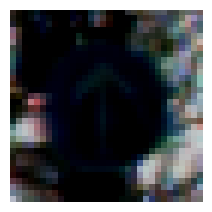

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 35
Label: Ahead only


In [ ]:
%matplotlib inline

# Index for the test image. Note: test dataset has ~12k images
index = 528

# Preparing image for predicting from test dataset
x_input = data['x_test'][index:index+1]
print(x_input.shape)
y_input = data['y_test'][index:index+1]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
scores = model.predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []

    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)

    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('/content/drive/MyDrive/project/dataset/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])



(1, 32, 32, 3)
[25]


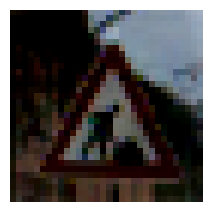

1/1 [==============================] - 0s 44ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[28]


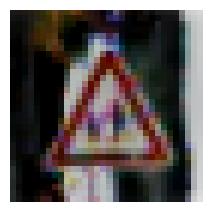

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 28


Label: Children crossing


(1, 32, 32, 3)
[3]


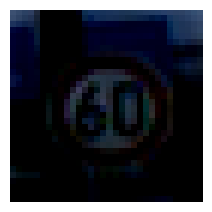

1/1 [==============================] - 0s 44ms/step
(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[39]


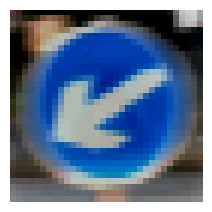

1/1 [==============================] - 0s 46ms/step
(43,)
ClassId: 39
Label: Keep left


(1, 32, 32, 3)
[25]


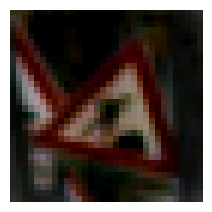

1/1 [==============================] - 0s 57ms/step
(43,)
ClassId: 30
Label: Beware of ice/snow


(1, 32, 32, 3)
[9]


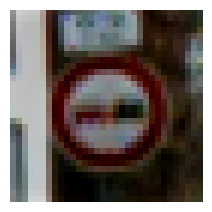

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[2]


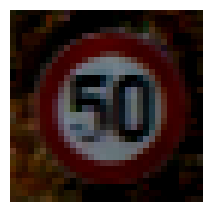

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[38]


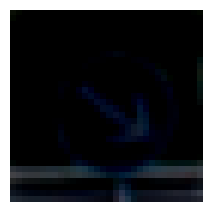

1/1 [==============================] - 0s 49ms/step
(43,)
ClassId: 38


Label: Keep right


(1, 32, 32, 3)
[10]


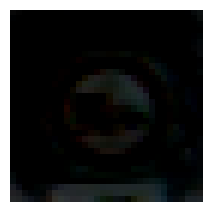

1/1 [==============================] - 0s 55ms/step
(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[38]


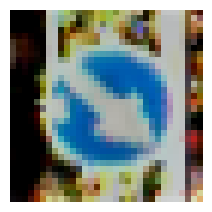

1/1 [==============================] - 0s 49ms/step
(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[4]


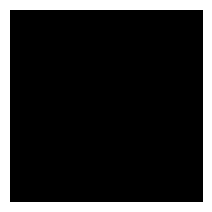

1/1 [==============================] - 0s 49ms/step


(43,)
ClassId: 4
Label: Speed limit (70km/h)


(1, 32, 32, 3)
[4]


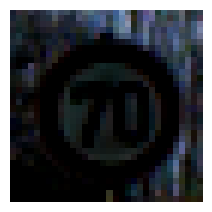

1/1 [==============================] - 0s 49ms/step
(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[1]


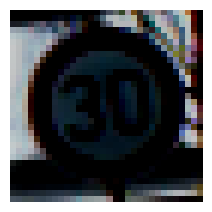

1/1 [==============================] - 0s 55ms/step
(43,)
ClassId: 1
Label: Speed limit (30km/h)




(1, 32, 32, 3)
[9]


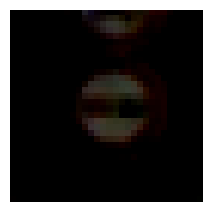

1/1 [==============================] - 0s 46ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[7]


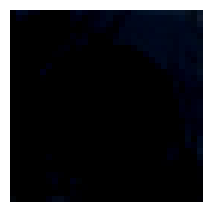

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[42]


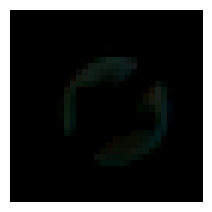

1/1 [==============================] - 0s 44ms/step
(43,)
ClassId: 42
Label: End of no passing by vehicles over 3.5 metric tons


(1, 32, 32, 3)
[33]


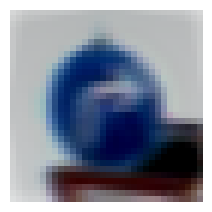

1/1 [==============================] - 0s 50ms/step
(43,)
ClassId: 33


Label: Turn right ahead


(1, 32, 32, 3)
[13]


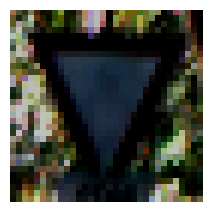

1/1 [==============================] - 0s 59ms/step
(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[3]


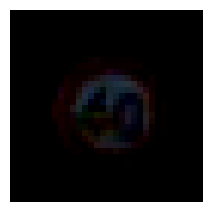

1/1 [==============================] - 0s 46ms/step
(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[9]


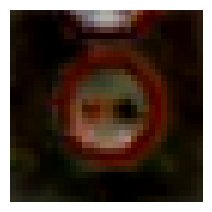

1/1 [==============================] - 0s 51ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[35]


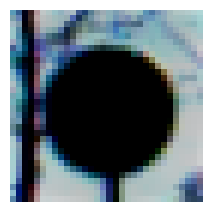

1/1 [==============================] - 0s 45ms/step
(43,)
ClassId: 35
Label: Ahead only


(1, 32, 32, 3)
[4]


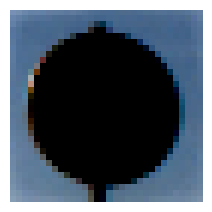

1/1 [==============================] - 0s 50ms/step
(43,)
ClassId: 5
Label: Speed limit (80km/h)


(1, 32, 32, 3)
[29]


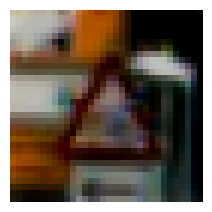

1/1 [==============================] - 0s 50ms/step
(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[8]


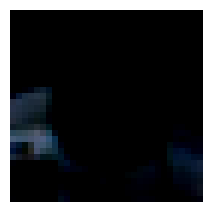

1/1 [==============================] - 0s 39ms/step
(43,)
ClassId: 8


Label: Speed limit (120km/h)


(1, 32, 32, 3)
[13]


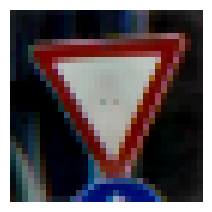

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 13


Label: Yield


(1, 32, 32, 3)
[2]


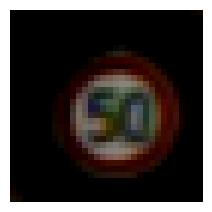

1/1 [==============================] - 0s 44ms/step
(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[3]


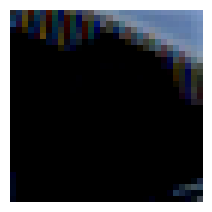

1/1 [==============================] - 0s 54ms/step
(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[13]


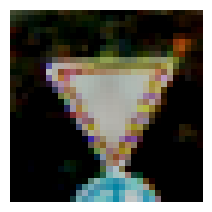

1/1 [==============================] - 0s 56ms/step
(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[18]


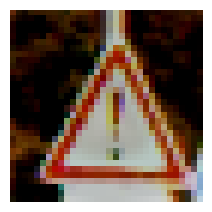

1/1 [==============================] - 0s 53ms/step


(43,)
ClassId: 18
Label: General caution


(1, 32, 32, 3)
[14]


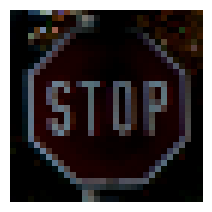

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 14
Label: Stop


(1, 32, 32, 3)
[9]


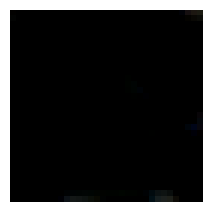

1/1 [==============================] - 0s 46ms/step
(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[5]


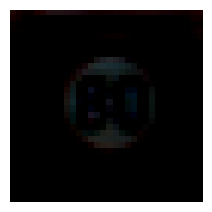

1/1 [==============================] - 0s 56ms/step
(43,)
ClassId: 5


Label: Speed limit (80km/h)


(1, 32, 32, 3)
[19]


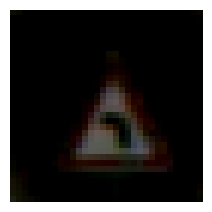

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 19
Label: Dangerous curve to the left


(1, 32, 32, 3)
[14]


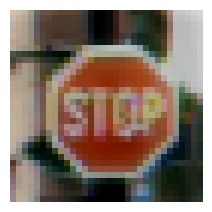

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 14
Label: Stop


(1, 32, 32, 3)
[13]


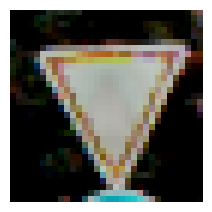

1/1 [==============================] - 0s 46ms/step
(43,)
ClassId: 13


Label: Yield


(1, 32, 32, 3)
[9]


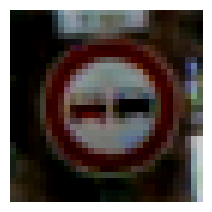

1/1 [==============================] - 0s 41ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[12]


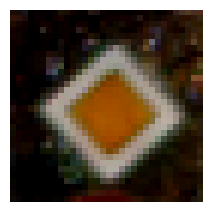

1/1 [==============================] - 0s 52ms/step
(43,)
ClassId: 12


Label: Priority road


(1, 32, 32, 3)
[24]


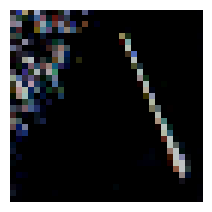

1/1 [==============================] - 0s 52ms/step


(43,)
ClassId: 24
Label: Road narrows on the right


(1, 32, 32, 3)
[34]


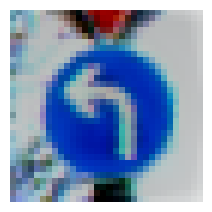

1/1 [==============================] - 0s 77ms/step


(43,)
ClassId: 34
Label: Turn left ahead


(1, 32, 32, 3)
[39]


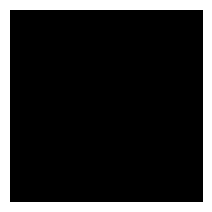

1/1 [==============================] - 0s 57ms/step


(43,)
ClassId: 39
Label: Keep left


(1, 32, 32, 3)
[30]


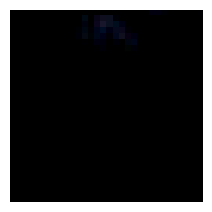

1/1 [==============================] - 0s 53ms/step


(43,)
ClassId: 30
Label: Beware of ice/snow


(1, 32, 32, 3)
[7]


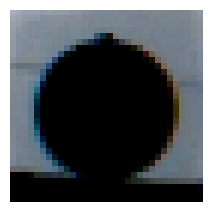

1/1 [==============================] - 0s 73ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[2]


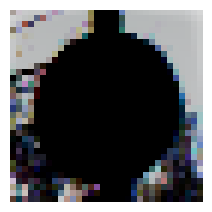

1/1 [==============================] - 0s 49ms/step


(43,)
ClassId: 5
Label: Speed limit (80km/h)


(1, 32, 32, 3)
[25]


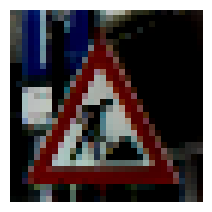

1/1 [==============================] - 0s 139ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[13]


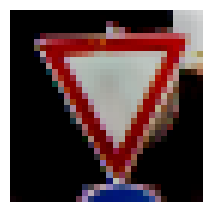

1/1 [==============================] - 0s 126ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[4]


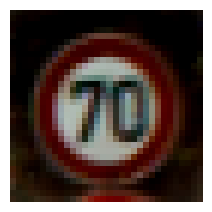

1/1 [==============================] - 0s 66ms/step


(43,)
ClassId: 4
Label: Speed limit (70km/h)


(1, 32, 32, 3)
[35]


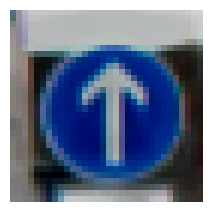

1/1 [==============================] - 0s 184ms/step


(43,)
ClassId: 35
Label: Ahead only


(1, 32, 32, 3)
[31]


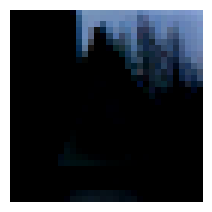

1/1 [==============================] - 0s 122ms/step


(43,)
ClassId: 31
Label: Wild animals crossing


(1, 32, 32, 3)
[4]


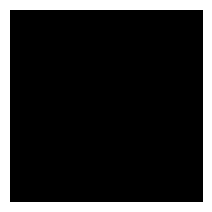

1/1 [==============================] - 0s 95ms/step


(43,)
ClassId: 4
Label: Speed limit (70km/h)


(1, 32, 32, 3)
[13]


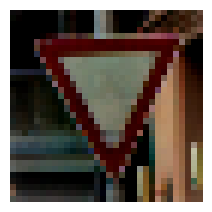

1/1 [==============================] - 0s 66ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[13]


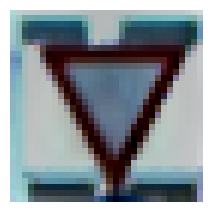

1/1 [==============================] - 0s 52ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[1]


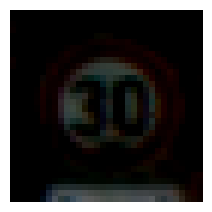

1/1 [==============================] - 0s 53ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[2]


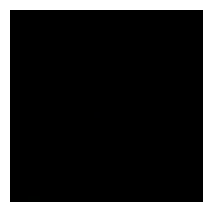

1/1 [==============================] - 0s 53ms/step


(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[17]


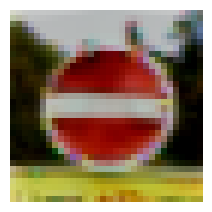

1/1 [==============================] - 0s 50ms/step
(43,)
ClassId: 17
Label: No entry


(1, 32, 32, 3)
[0]


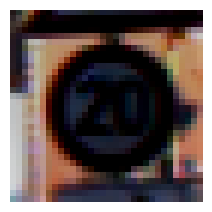

1/1 [==============================] - 0s 45ms/step
(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[4]


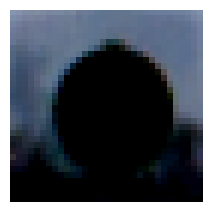

1/1 [==============================] - 0s 46ms/step
(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[7]


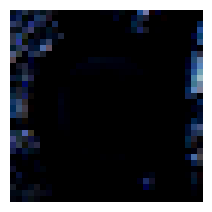

1/1 [==============================] - 0s 52ms/step
(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[10]


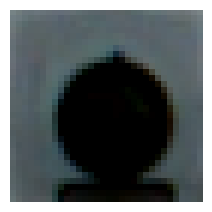

1/1 [==============================] - 0s 54ms/step


(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[9]


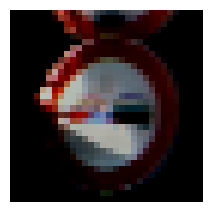

1/1 [==============================] - 0s 50ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[25]


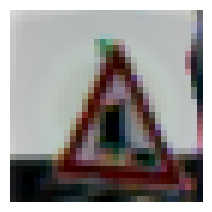

1/1 [==============================] - 0s 38ms/step


(43,)
ClassId: 11
Label: Right-of-way at the next intersection


(1, 32, 32, 3)
[8]


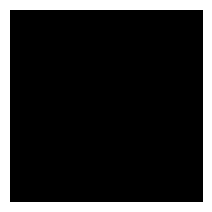

1/1 [==============================] - 0s 47ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[0]


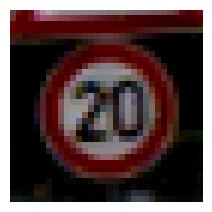

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 0


Label: Speed limit (20km/h)


(1, 32, 32, 3)
[38]


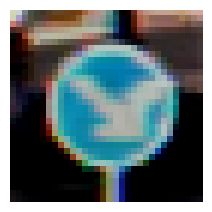

1/1 [==============================] - 0s 43ms/step
(43,)
ClassId: 38


Label: Keep right


(1, 32, 32, 3)
[38]


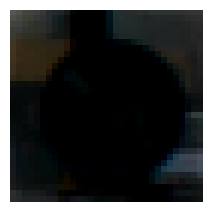

1/1 [==============================] - 0s 61ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[1]


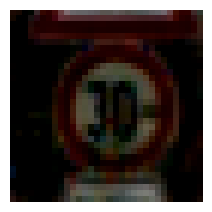

1/1 [==============================] - 0s 43ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[2]


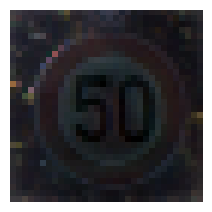

1/1 [==============================] - 0s 50ms/step


(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[38]


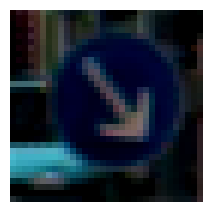

1/1 [==============================] - 0s 36ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[12]


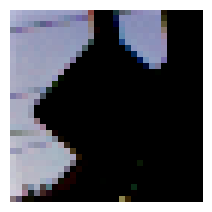

1/1 [==============================] - 0s 53ms/step
(43,)
ClassId: 12


Label: Priority road


(1, 32, 32, 3)
[10]


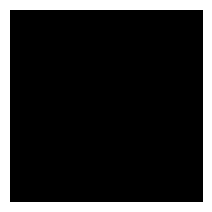

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[12]


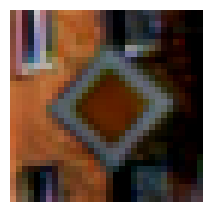

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 12


Label: Priority road


(1, 32, 32, 3)
[4]


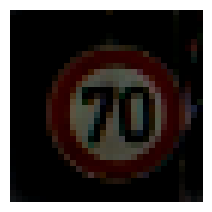

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[10]


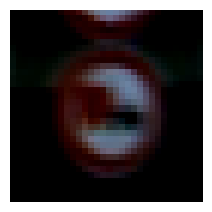

1/1 [==============================] - 0s 53ms/step
(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[7]


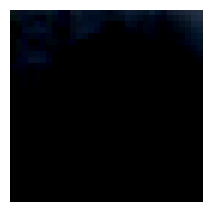

1/1 [==============================] - 0s 46ms/step
(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[24]


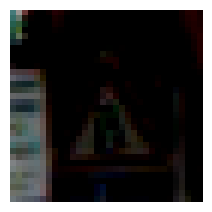

1/1 [==============================] - 0s 59ms/step
(43,)
ClassId: 27


Label: Pedestrians


(1, 32, 32, 3)
[31]


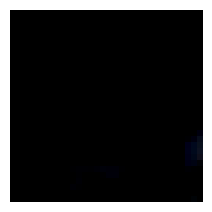

1/1 [==============================] - 0s 40ms/step
(43,)
ClassId: 31


Label: Wild animals crossing


(1, 32, 32, 3)
[15]


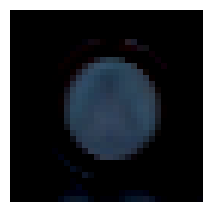

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 15
Label: No vehicles


(1, 32, 32, 3)
[4]


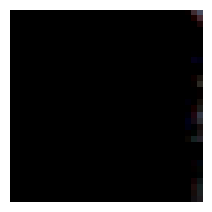

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 4
Label: Speed limit (70km/h)


(1, 32, 32, 3)
[2]


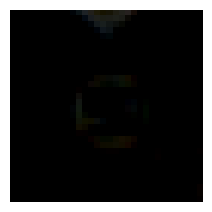

1/1 [==============================] - 0s 51ms/step
(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[13]


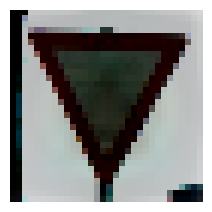

1/1 [==============================] - 0s 37ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[10]


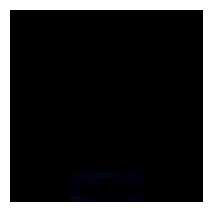

1/1 [==============================] - 0s 42ms/step
(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[12]


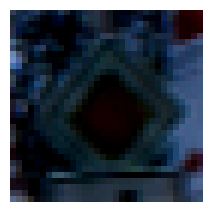

1/1 [==============================] - 0s 51ms/step
(43,)
ClassId: 12
Label: Priority road


(1, 32, 32, 3)
[7]


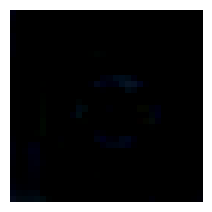

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[11]


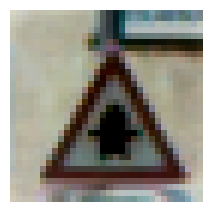

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 11
Label: Right-of-way at the next intersection


(1, 32, 32, 3)
[15]


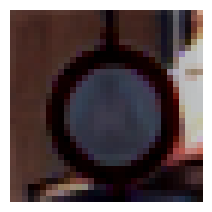

1/1 [==============================] - 0s 45ms/step
(43,)
ClassId: 15


Label: No vehicles


(1, 32, 32, 3)
[31]


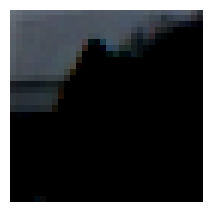

1/1 [==============================] - 0s 105ms/step


(43,)
ClassId: 31
Label: Wild animals crossing


(1, 32, 32, 3)
[34]


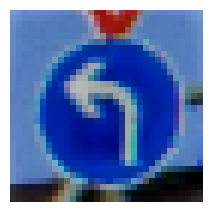

1/1 [==============================] - 0s 71ms/step


(43,)
ClassId: 34
Label: Turn left ahead


(1, 32, 32, 3)
[42]


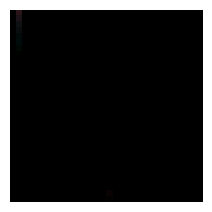

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 42
Label: End of no passing by vehicles over 3.5 metric tons


(1, 32, 32, 3)
[7]


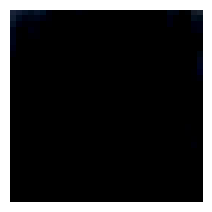

1/1 [==============================] - 0s 56ms/step
(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[42]


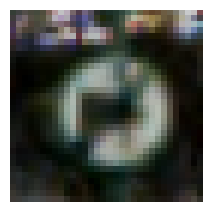

1/1 [==============================] - 0s 78ms/step


(43,)
ClassId: 42
Label: End of no passing by vehicles over 3.5 metric tons


(1, 32, 32, 3)
[30]


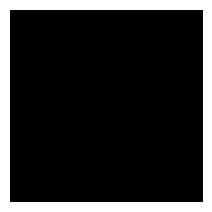

1/1 [==============================] - 0s 64ms/step


(43,)
ClassId: 23
Label: Slippery road


(1, 32, 32, 3)
[2]


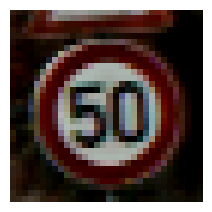

1/1 [==============================] - 0s 51ms/step
(43,)
ClassId: 2


Label: Speed limit (50km/h)


(1, 32, 32, 3)
[26]


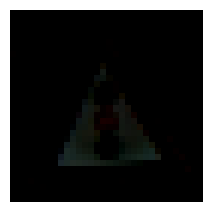

1/1 [==============================] - 0s 52ms/step


(43,)
ClassId: 26
Label: Traffic signals


(1, 32, 32, 3)
[8]


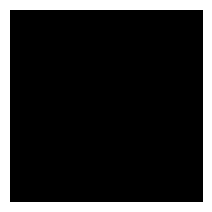

1/1 [==============================] - 0s 56ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[26]


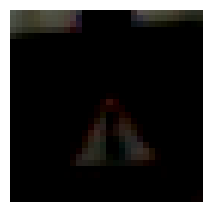

1/1 [==============================] - 0s 49ms/step


(43,)
ClassId: 26
Label: Traffic signals


(1, 32, 32, 3)
[36]


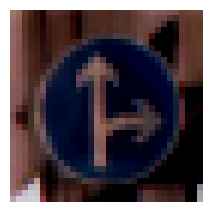

1/1 [==============================] - 0s 47ms/step


(43,)
ClassId: 36
Label: Go straight or right


(1, 32, 32, 3)
[25]


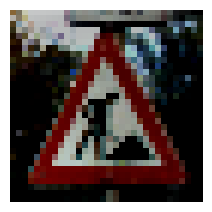

1/1 [==============================] - 0s 46ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[8]


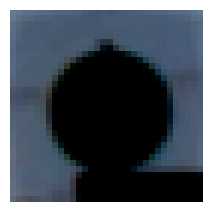

1/1 [==============================] - 0s 75ms/step


(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[13]


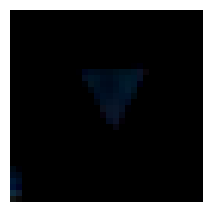

1/1 [==============================] - 0s 73ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[25]


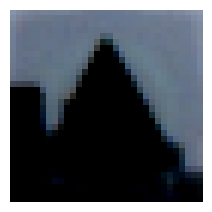

1/1 [==============================] - 0s 68ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[17]


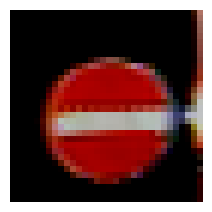

1/1 [==============================] - 0s 63ms/step


(43,)
ClassId: 14
Label: Stop


(1, 32, 32, 3)
[38]


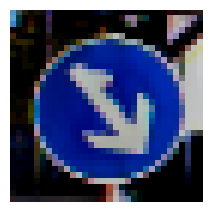

1/1 [==============================] - 0s 57ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[25]


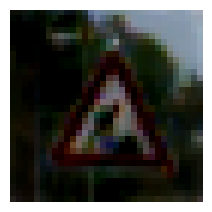

1/1 [==============================] - 0s 61ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[28]


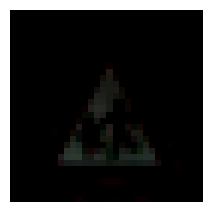

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 28
Label: Children crossing


(1, 32, 32, 3)
[12]


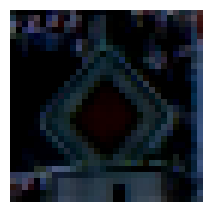

1/1 [==============================] - 0s 71ms/step


(43,)
ClassId: 12
Label: Priority road


(1, 32, 32, 3)
[41]


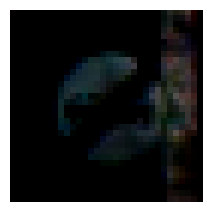

1/1 [==============================] - 0s 90ms/step


(43,)
ClassId: 41
Label: End of no passing


(1, 32, 32, 3)
[6]


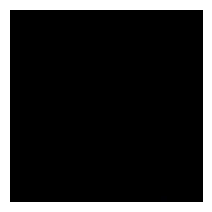

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 6
Label: End of speed limit (80km/h)


(1, 32, 32, 3)
[19]


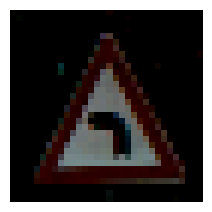

1/1 [==============================] - 0s 64ms/step


(43,)
ClassId: 19
Label: Dangerous curve to the left


(1, 32, 32, 3)
[25]


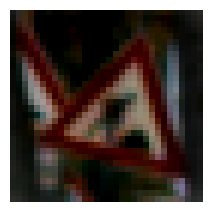

1/1 [==============================] - 0s 58ms/step


(43,)
ClassId: 15
Label: No vehicles


(1, 32, 32, 3)
[1]


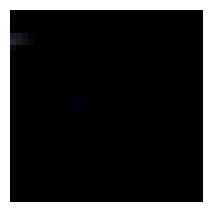

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 4
Label: Speed limit (70km/h)


(1, 32, 32, 3)
[15]


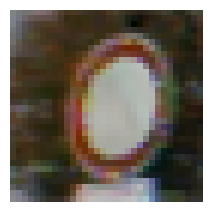

1/1 [==============================] - 0s 60ms/step


(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[6]


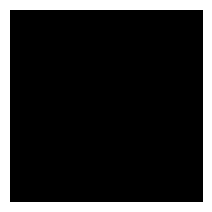

1/1 [==============================] - 0s 57ms/step


(43,)
ClassId: 6
Label: End of speed limit (80km/h)


(1, 32, 32, 3)
[38]


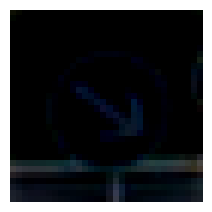

1/1 [==============================] - 0s 77ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[1]


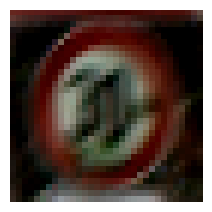

1/1 [==============================] - 0s 60ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[18]


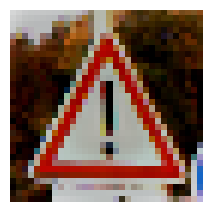

1/1 [==============================] - 0s 68ms/step


(43,)
ClassId: 18
Label: General caution


(1, 32, 32, 3)
[7]


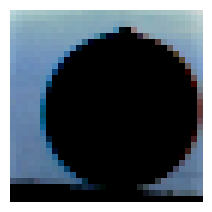

1/1 [==============================] - 0s 60ms/step


(43,)
ClassId: 5
Label: Speed limit (80km/h)


(1, 32, 32, 3)
[2]


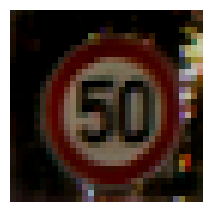

1/1 [==============================] - 0s 54ms/step


(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[9]


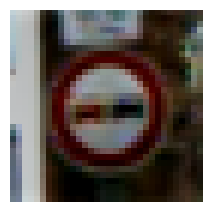

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[22]


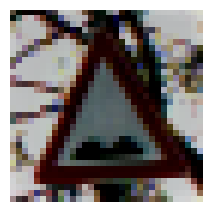

1/1 [==============================] - 0s 50ms/step


(43,)
ClassId: 22
Label: Bumpy road


(1, 32, 32, 3)
[3]


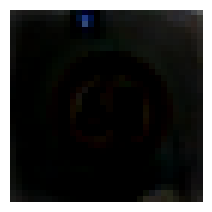

1/1 [==============================] - 0s 51ms/step
(43,)
ClassId: 3


Label: Speed limit (60km/h)


(1, 32, 32, 3)
[1]


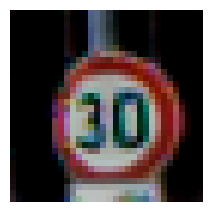

1/1 [==============================] - 0s 51ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[38]


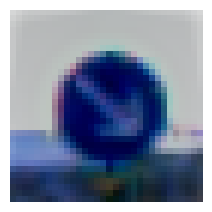

1/1 [==============================] - 0s 42ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[10]


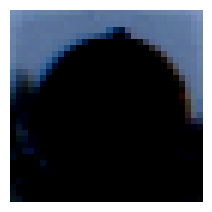

1/1 [==============================] - 0s 65ms/step


(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[15]


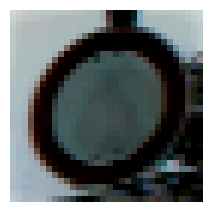

1/1 [==============================] - 0s 47ms/step
(43,)
ClassId: 8


Label: Speed limit (120km/h)


(1, 32, 32, 3)
[3]


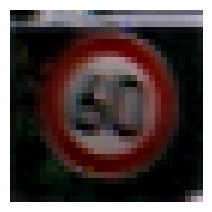

1/1 [==============================] - 0s 41ms/step


(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[19]


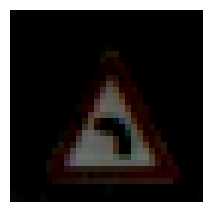

1/1 [==============================] - 0s 41ms/step
(43,)
ClassId: 19
Label: Dangerous curve to the left


(1, 32, 32, 3)
[18]


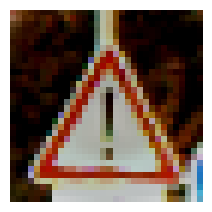

1/1 [==============================] - 0s 40ms/step


(43,)
ClassId: 18
Label: General caution


(1, 32, 32, 3)
[9]


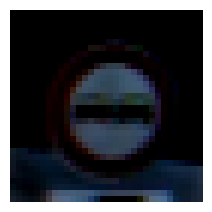

1/1 [==============================] - 0s 45ms/step
(43,)
ClassId: 9


Label: No passing


(1, 32, 32, 3)
[25]


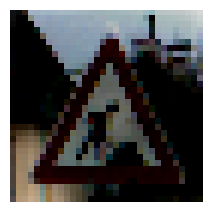

1/1 [==============================] - 0s 44ms/step
(43,)
ClassId: 25


Label: Road work


(1, 32, 32, 3)
[31]


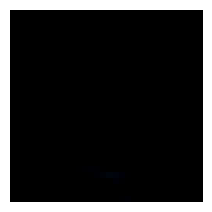

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 31
Label: Wild animals crossing


(1, 32, 32, 3)
[4]


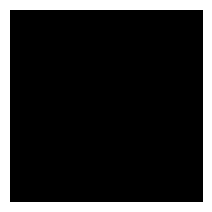

1/1 [==============================] - 0s 49ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[16]


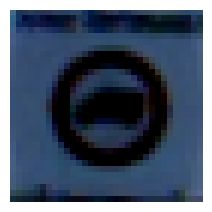

1/1 [==============================] - 0s 48ms/step


(43,)
ClassId: 16
Label: Vehicles over 3.5 metric tons prohibited


(1, 32, 32, 3)
[3]


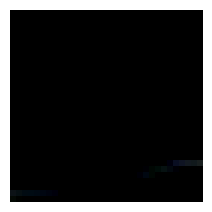

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[1]


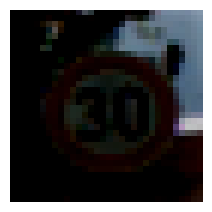

1/1 [==============================] - 0s 39ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[25]


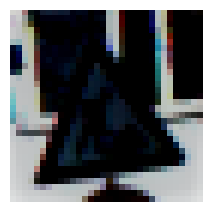

1/1 [==============================] - 0s 40ms/step
(43,)
ClassId: 25
Label:

 Road work


(1, 32, 32, 3)
[11]


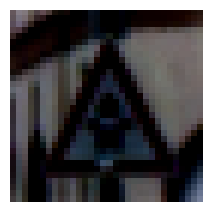

1/1 [==============================] - 0s 49ms/step
(43,)
ClassId: 11
Label: Right-of-way at the next intersection


(1, 32, 32, 3)
[10]


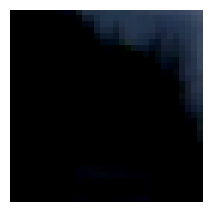

1/1 [==============================] - 0s 50ms/step
(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[18]


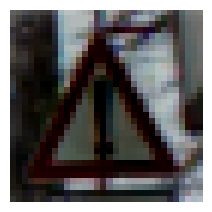

1/1 [==============================] - 0s 55ms/step
(43,)
ClassId: 18
Label: General caution


(1, 32, 32, 3)
[30]


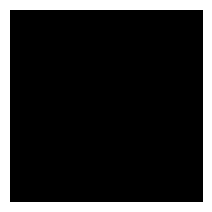

1/1 [==============================] - 0s 44ms/step


(43,)
ClassId: 30
Label: Beware of ice/snow


(1, 32, 32, 3)
[11]


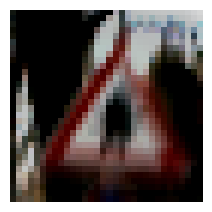

1/1 [==============================] - 0s 44ms/step
(43,)
ClassId: 11


Label: Right-of-way at the next intersection


(1, 32, 32, 3)
[13]


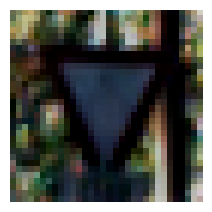

1/1 [==============================] - 0s 51ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[12]


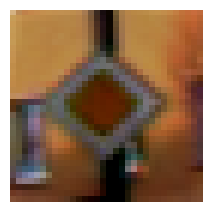

1/1 [==============================] - 0s 52ms/step
(43,)
ClassId: 12


Label: Priority road


(1, 32, 32, 3)
[38]


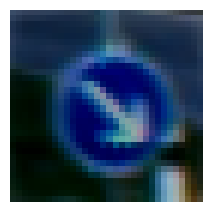

1/1 [==============================] - 0s 37ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[0]


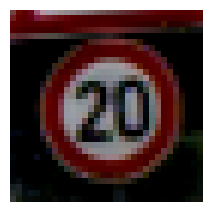

1/1 [==============================] - 0s 42ms/step


(43,)
ClassId: 0
Label: Speed limit (20km/h)


(1, 32, 32, 3)
[35]


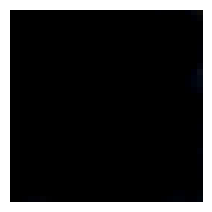

1/1 [==============================] - 0s 41ms/step


(43,)
ClassId: 35
Label: Ahead only


(1, 32, 32, 3)
[3]


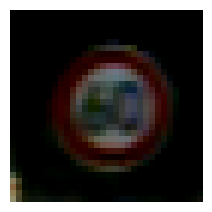

1/1 [==============================] - 0s 42ms/step


(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[10]


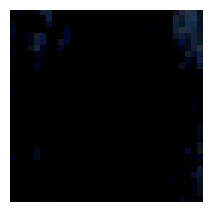

1/1 [==============================] - 0s 39ms/step


(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[36]


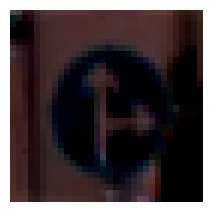

1/1 [==============================] - 0s 35ms/step


(43,)
ClassId: 36
Label: Go straight or right


(1, 32, 32, 3)
[37]


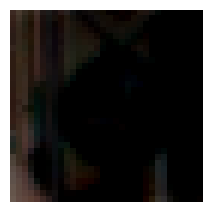

1/1 [==============================] - 0s 41ms/step
(43,)
ClassId: 37


Label: Go straight or left


(1, 32, 32, 3)
[38]


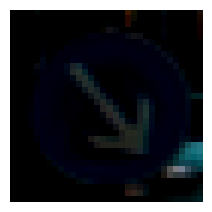

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 38


Label: Keep right


(1, 32, 32, 3)
[13]


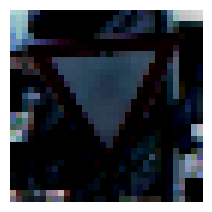

1/1 [==============================] - 0s 37ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[13]


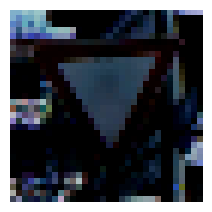

1/1 [==============================] - 0s 39ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[5]


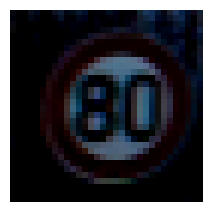

1/1 [==============================] - 0s 35ms/step


(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[9]


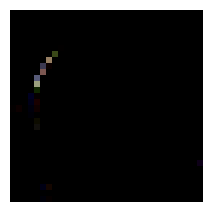

1/1 [==============================] - 0s 56ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[1]


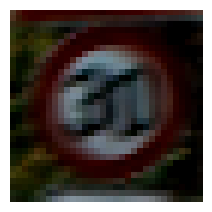

1/1 [==============================] - 0s 42ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[5]


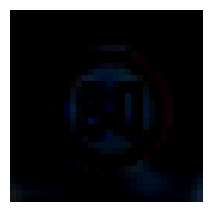

1/1 [==============================] - 0s 41ms/step


(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[11]


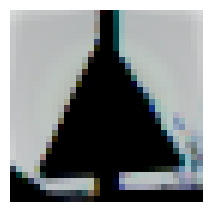

1/1 [==============================] - 0s 58ms/step


(43,)
ClassId: 26
Label: Traffic signals


(1, 32, 32, 3)
[5]


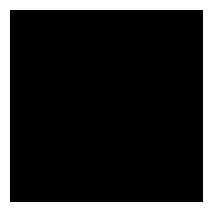

1/1 [==============================] - 0s 44ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[18]


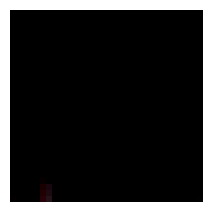

1/1 [==============================] - 0s 46ms/step


(43,)
ClassId: 26
Label: Traffic signals


(1, 32, 32, 3)
[18]


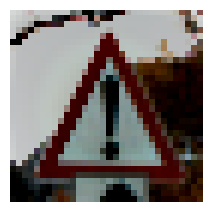

1/1 [==============================] - 0s 51ms/step


(43,)
ClassId: 18
Label: General caution


(1, 32, 32, 3)
[2]


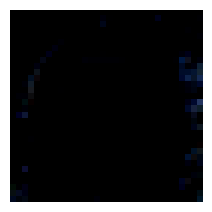

1/1 [==============================] - 0s 44ms/step


(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[39]


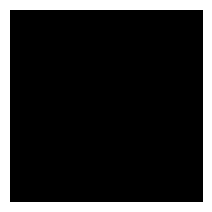

1/1 [==============================] - 0s 42ms/step


(43,)
ClassId: 39
Label: Keep left


(1, 32, 32, 3)
[42]


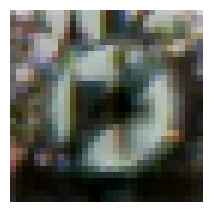

1/1 [==============================] - 0s 49ms/step
(43,)
ClassId: 42


Label: End of no passing by vehicles over 3.5 metric tons


(1, 32, 32, 3)
[1]


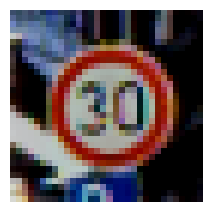

1/1 [==============================] - 0s 58ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[3]


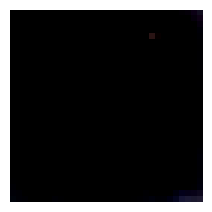

1/1 [==============================] - 0s 58ms/step


(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[40]


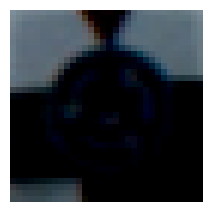

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 40
Label: Roundabout mandatory


(1, 32, 32, 3)
[36]


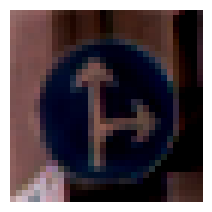

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 36
Label: Go straight or right


(1, 32, 32, 3)
[25]


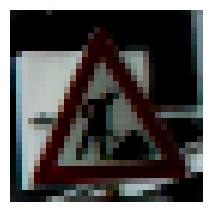

1/1 [==============================] - 0s 67ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[5]


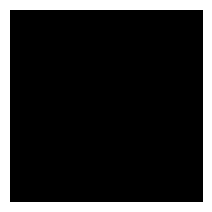

1/1 [==============================] - 0s 84ms/step


(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[7]


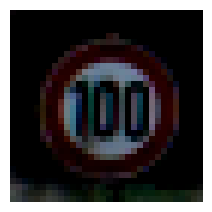

1/1 [==============================] - 0s 60ms/step


(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[13]


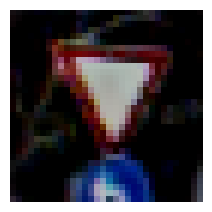

1/1 [==============================] - 0s 65ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[13]


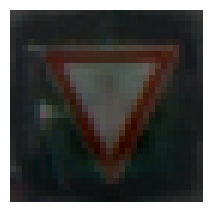

1/1 [==============================] - 0s 69ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[36]


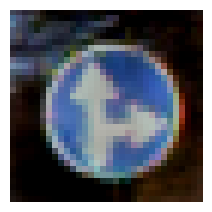

1/1 [==============================] - 0s 53ms/step


(43,)
ClassId: 36
Label: Go straight or right


(1, 32, 32, 3)
[4]


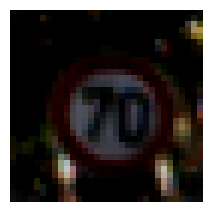

1/1 [==============================] - 0s 59ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[40]


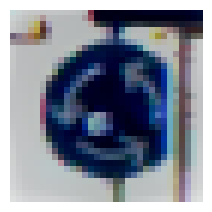

1/1 [==============================] - 0s 74ms/step


(43,)
ClassId: 37
Label: Go straight or left


(1, 32, 32, 3)
[8]


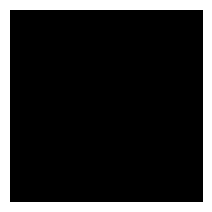

1/1 [==============================] - 0s 60ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[14]


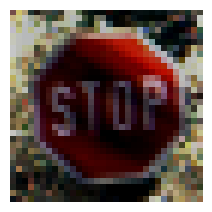

1/1 [==============================] - 0s 58ms/step


(43,)
ClassId: 14
Label: Stop


(1, 32, 32, 3)
[31]


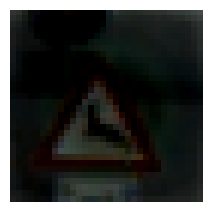

1/1 [==============================] - 0s 67ms/step


(43,)
ClassId: 31
Label: Wild animals crossing


(1, 32, 32, 3)
[13]


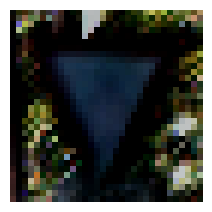

1/1 [==============================] - 0s 76ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[14]


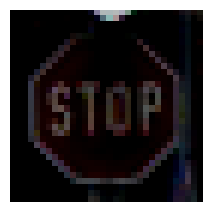

1/1 [==============================] - 0s 90ms/step


(43,)
ClassId: 14
Label: Stop


(1, 32, 32, 3)
[4]


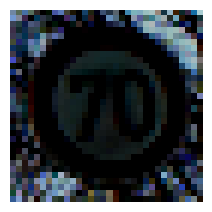

1/1 [==============================] - 0s 97ms/step


(43,)
ClassId: 4
Label: Speed limit (70km/h)


(1, 32, 32, 3)
[14]


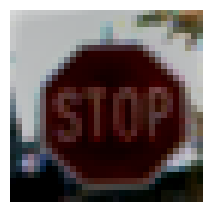

1/1 [==============================] - 0s 58ms/step


(43,)
ClassId: 14
Label: Stop


(1, 32, 32, 3)
[18]


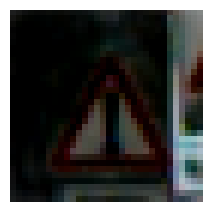

1/1 [==============================] - 0s 54ms/step


(43,)
ClassId: 18
Label: General caution


(1, 32, 32, 3)
[3]


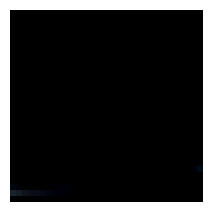

1/1 [==============================] - 0s 62ms/step


(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[29]


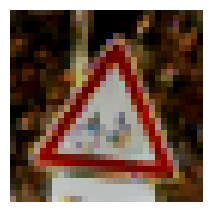

1/1 [==============================] - 0s 37ms/step


(43,)
ClassId: 29
Label: Bicycles crossing


(1, 32, 32, 3)
[22]


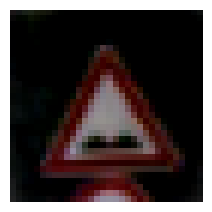

1/1 [==============================] - 0s 43ms/step
(43,)
ClassId: 22
Label: Bumpy road


(1, 32, 32, 3)
[2]


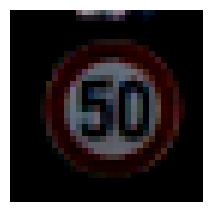

1/1 [==============================] - 0s 38ms/step


(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[40]


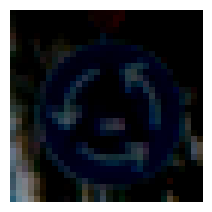

1/1 [==============================] - 0s 48ms/step


(43,)
ClassId: 40
Label: Roundabout mandatory


(1, 32, 32, 3)
[11]


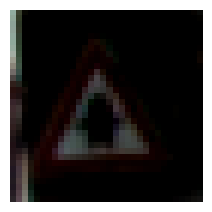

1/1 [==============================] - 0s 43ms/step


(43,)
ClassId: 11
Label: Right-of-way at the next intersection


(1, 32, 32, 3)
[1]


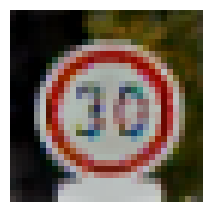

1/1 [==============================] - 0s 45ms/step


(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[7]


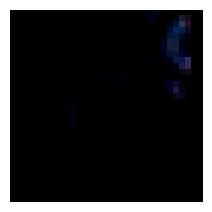

1/1 [==============================] - 0s 35ms/step


(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[4]


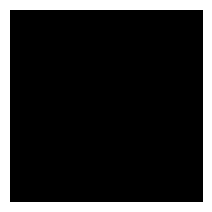

1/1 [==============================] - 0s 40ms/step


(43,)
ClassId: 4
Label: Speed limit (70km/h)


(1, 32, 32, 3)
[38]


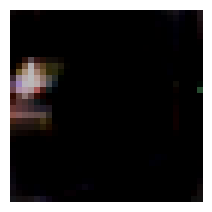

1/1 [==============================] - 0s 33ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[21]


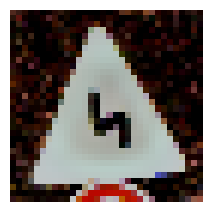

1/1 [==============================] - 0s 43ms/step
(43,)
ClassId: 19


Label: Dangerous curve to the left


(1, 32, 32, 3)
[10]


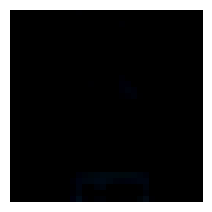

1/1 [==============================] - 0s 38ms/step
(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[18]


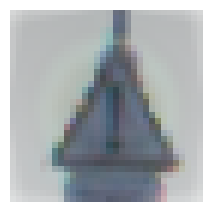

1/1 [==============================] - 0s 44ms/step
(43,)
ClassId: 18


Label: General caution


(1, 32, 32, 3)
[26]


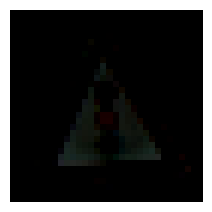

1/1 [==============================] - 0s 41ms/step


(43,)
ClassId: 26
Label: Traffic signals


(1, 32, 32, 3)
[17]


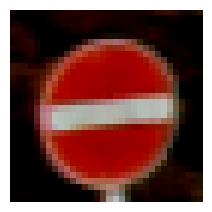

1/1 [==============================] - 0s 50ms/step


(43,)
ClassId: 17
Label: No entry


(1, 32, 32, 3)
[7]


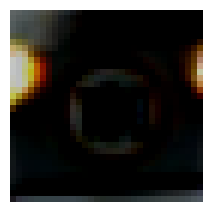

1/1 [==============================] - 0s 53ms/step


(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[13]


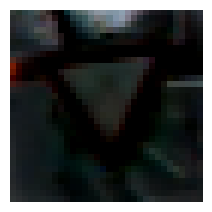

1/1 [==============================] - 0s 40ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[31]


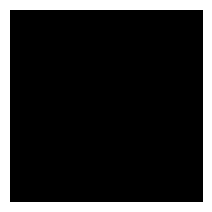

1/1 [==============================] - 0s 42ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[41]


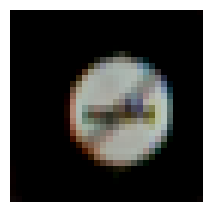

1/1 [==============================] - 0s 46ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[3]


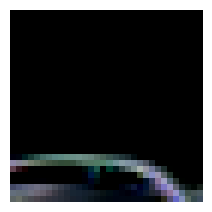

1/1 [==============================] - 0s 39ms/step


(43,)
ClassId: 6
Label: End of speed limit (80km/h)


(1, 32, 32, 3)
[10]


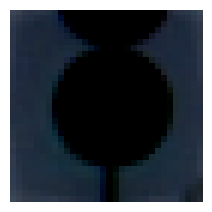

1/1 [==============================] - 0s 42ms/step


(43,)
ClassId: 10
Label: No passing for vehicles over 3.5 metric tons


(1, 32, 32, 3)
[38]


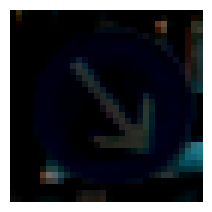

1/1 [==============================] - 0s 58ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[30]


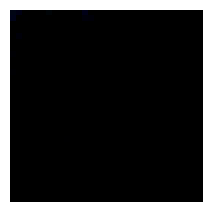

1/1 [==============================] - 0s 48ms/step
(43,)
ClassId: 30
Label: Beware of ice/snow


(1, 32, 32, 3)
[18]


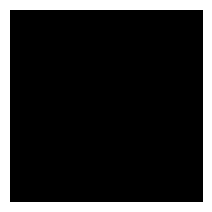

1/1 [==============================] - 0s 37ms/step


(43,)
ClassId: 18
Label: General caution


(1, 32, 32, 3)
[38]


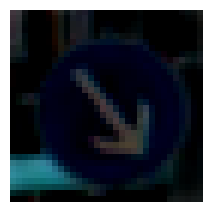

1/1 [==============================] - 0s 49ms/step
(43,)
ClassId: 38


Label: Keep right


(1, 32, 32, 3)
[35]


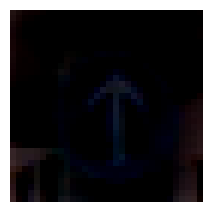

1/1 [==============================] - 0s 46ms/step
(43,)
ClassId: 35


Label: Ahead only


(1, 32, 32, 3)
[38]


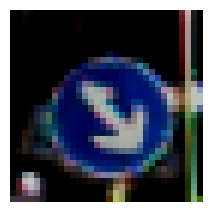

1/1 [==============================] - 0s 48ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[11]


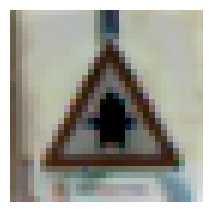

1/1 [==============================] - 0s 65ms/step


(43,)
ClassId: 11
Label: Right-of-way at the next intersection


(1, 32, 32, 3)
[1]


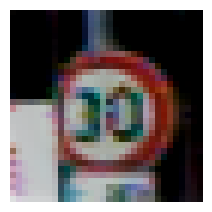

1/1 [==============================] - 0s 40ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[30]


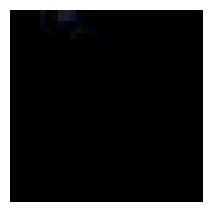

1/1 [==============================] - 0s 52ms/step


(43,)
ClassId: 19
Label: Dangerous curve to the left


(1, 32, 32, 3)
[31]


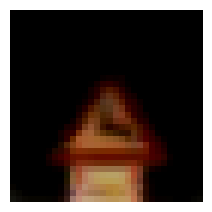

1/1 [==============================] - 0s 37ms/step
(43,)
ClassId: 31
Label: Wild animals crossing


(1, 32, 32, 3)
[4]


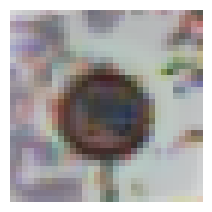

1/1 [==============================] - 0s 40ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)


(1, 32, 32, 3)
[25]


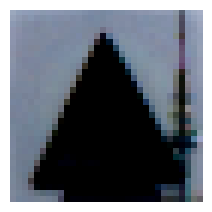

1/1 [==============================] - 0s 61ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[30]


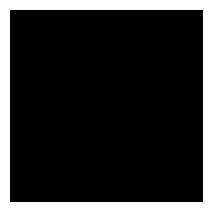

1/1 [==============================] - 0s 43ms/step


(43,)
ClassId: 30
Label: Beware of ice/snow


(1, 32, 32, 3)
[6]


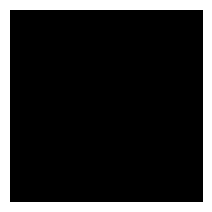

1/1 [==============================] - 0s 41ms/step


(43,)
ClassId: 6
Label: End of speed limit (80km/h)


(1, 32, 32, 3)
[17]


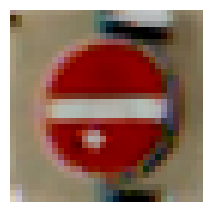

1/1 [==============================] - 0s 36ms/step


(43,)
ClassId: 17
Label: No entry


(1, 32, 32, 3)
[21]


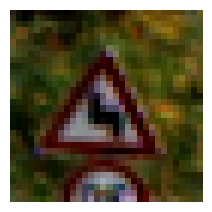

1/1 [==============================] - 0s 42ms/step


(43,)
ClassId: 31
Label: Wild animals crossing


(1, 32, 32, 3)
[31]


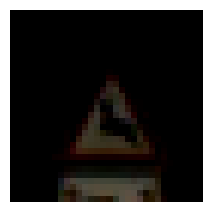

1/1 [==============================] - 0s 37ms/step


(43,)
ClassId: 31
Label: Wild animals crossing


(1, 32, 32, 3)
[16]


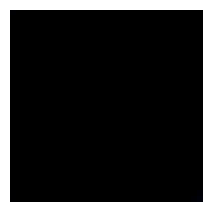

1/1 [==============================] - 0s 52ms/step


(43,)
ClassId: 16
Label: Vehicles over 3.5 metric tons prohibited


(1, 32, 32, 3)
[3]


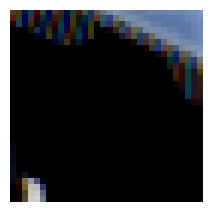

1/1 [==============================] - 0s 43ms/step


(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[9]


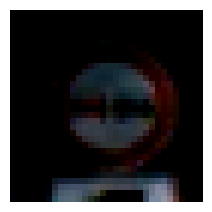

1/1 [==============================] - 0s 37ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[13]


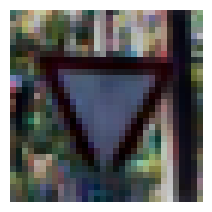

1/1 [==============================] - 0s 45ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[26]


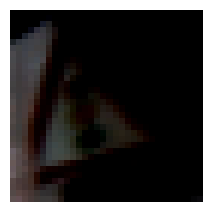

1/1 [==============================] - 0s 37ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[38]


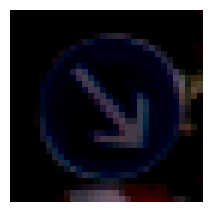

1/1 [==============================] - 0s 36ms/step


(43,)
ClassId: 38
Label: Keep right


(1, 32, 32, 3)
[13]


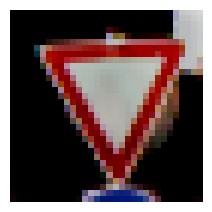

1/1 [==============================] - 0s 40ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[25]


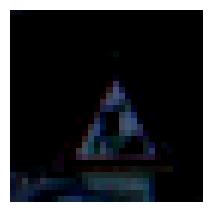

1/1 [==============================] - 0s 87ms/step


(43,)
ClassId: 25
Label: Road work


(1, 32, 32, 3)
[7]


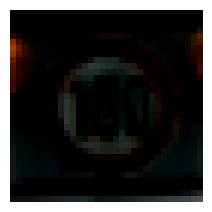

1/1 [==============================] - 0s 66ms/step


(43,)
ClassId: 7
Label: Speed limit (100km/h)


(1, 32, 32, 3)
[2]


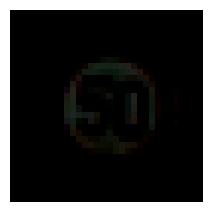

1/1 [==============================] - 0s 78ms/step


(43,)
ClassId: 2
Label: Speed limit (50km/h)


(1, 32, 32, 3)
[31]


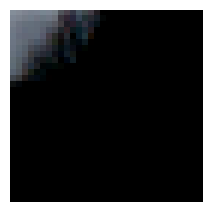

1/1 [==============================] - 0s 76ms/step


(43,)
ClassId: 31
Label: Wild animals crossing


(1, 32, 32, 3)
[2]


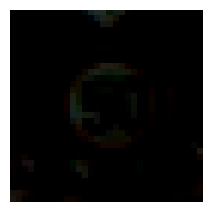

1/1 [==============================] - 0s 78ms/step


(43,)
ClassId: 1
Label: Speed limit (30km/h)


(1, 32, 32, 3)
[12]


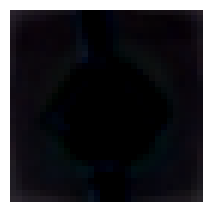

1/1 [==============================] - 0s 70ms/step


(43,)
ClassId: 12
Label: Priority road


(1, 32, 32, 3)
[16]


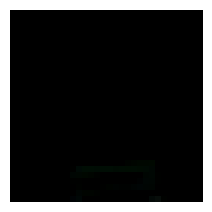

1/1 [==============================] - 0s 60ms/step


(43,)
ClassId: 0
Label: Speed limit (20km/h)


(1, 32, 32, 3)
[3]


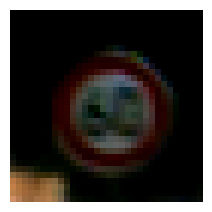

1/1 [==============================] - 0s 107ms/step


(43,)
ClassId: 3
Label: Speed limit (60km/h)


(1, 32, 32, 3)
[13]


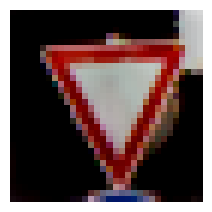

1/1 [==============================] - 0s 73ms/step


(43,)
ClassId: 13
Label: Yield


(1, 32, 32, 3)
[12]


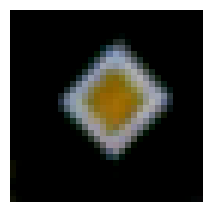

1/1 [==============================] - 0s 91ms/step


(43,)
ClassId: 12
Label: Priority road


(1, 32, 32, 3)
[27]


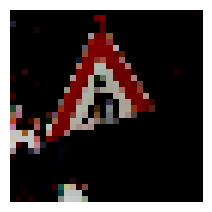

1/1 [==============================] - 0s 108ms/step


(43,)
ClassId: 26
Label: Traffic signals


(1, 32, 32, 3)
[9]


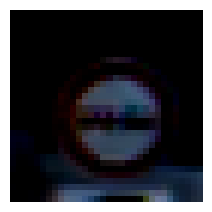

1/1 [==============================] - 0s 114ms/step


(43,)
ClassId: 9
Label: No passing


(1, 32, 32, 3)
[35]


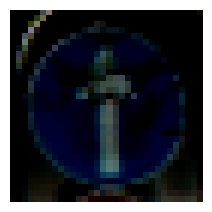

1/1 [==============================] - 0s 105ms/step
(43,)
ClassId: 35
Label: Ahead only



In [ ]:
# Predicting around ~240 images from test set
for index in range(0,12000, 50):
    print()
    # Preparing image for predicting from test dataset
    x_input = data['x_test'][index:index+1]
    print(x_input.shape)
    y_input = data['y_test'][index:index+1]
    print(y_input)

    plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
    plt.imshow(x_input[0, :, :, :])
    plt.axis('off')

    # Showing the plot
    plt.show()

    # Getting scores from forward pass of input image
    scores = model.predict(x_input)
    print(scores[0].shape) # (43,)

    # Scores is given for image with 43 numbers of predictions for each class
    # Getting only one class with maximum value
    prediction = np.argmax(scores)
    print('ClassId:', prediction)

    # Defining function for getting texts for every class - labels
    def label_text(file):
        # Defining list for saving label in order from 0 to 42
        label_list = []

        # Reading 'csv' file and getting image's labels
        r = pd.read_csv(file)
        # Going through all names
        for name in r['SignName']:
            # Adding from every row second column with name of the label
            label_list.append(name)

        # Returning resulted list with labels
        return label_list


    # Getting labels
    labels = label_text('/content/drive/MyDrive/project/dataset/label_names.csv')

    # Printing label for classified Traffic Sign
    print('Label:', labels[prediction])
    print()

